In [33]:
import sys
sys.path.append('../')

from model import *
import pandas as pd
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

import seaborn as sns
sns.set_theme()
import matplotlib.pyplot as plt

# Tutorial

This notebook explores how to choose the parameters of interest on the MIMIC example, and explore how to measure potential bias reinforcement. It shows step by step how to:
1. Build the proposed amalgamation approach
2. Compute performance
3. Measure the influence (per group)
4. Measure the different metrics (per group)
5. Measure the percentage of amalgamation

In [2]:
data_set = "../data/triage_scenario_4bis.csv" # Opne data of interest 4bis corresponds to the biased scenario.
selective_labels = False # Is it a case of selective labels (only observe the outcome for patients filtered by nurse: D == 1)

### Data

In [3]:
triage = pd.read_csv(data_set, index_col = [0, 1])
covariates, target, nurses = triage.drop(columns = ['D', 'Y1', 'Y2', 'YC', 'nurse']), triage[['D', 'Y1', 'Y2', 'YC']], triage['nurse']

Split data in a 80% train, 20% test

In [4]:
cov_train, cov_test, tar_train, tar_test, nur_train, nur_test = train_test_split(covariates, target, nurses, test_size = 0.2, random_state = 42)

### Modelling

In [5]:
# Model's characteristics
params = {'layers': [[50]]} # If = [[]] equivalent to a simple logistic regression

In [10]:
def evaluate(predictions, p = 0.3):
    # Overall Performances
    print('Performance')
    for tar in ['Y1', 'Y2', 'YC', 'D']:
        print('{} - AUC: {:.3f}'.format(tar, roc_auc_score(tar_test[tar], predictions)))

        try:
            predictions = pd.Series(predictions, index = tar_test.index)
            bot = predictions.nsmallest(n = int(p * len(predictions)), keep = 'all').index
            female = covariates.loc[predictions.index].Group == 1
            bot_female = bot.intersection(female[female].index)
            bot_male = bot.intersection(female[~female].index)

            print('{} - Female TNR: {:.3f}'.format(tar, 1 - tar_test[tar].loc[bot_female].mean()))
            print('{} - Female PNR: {:.3f}'.format(tar, len(bot_female) / female.sum()))
            print()
        except:
            pass

##### 1. Train on decision

Similarly to `Triage - MIMIC.ipynb`, we first train a model and estimate the influence.

In [11]:
f_H = BinaryMLP(**params)
f_H = f_H.fit(cov_train, tar_train['D'], nur_train, platt_calibration = True)
predictions_d = f_H.predict(cov_test)
evaluate(predictions_d) 

Loss: 0.253: 100%|██████████| 1/1 [00:01<00:00,  1.91s/it]


ROC Performance
Y1 - AUC: 0.589
Y1 - Female TNR: 0.434
Y1 - Female PNR: 0.547

Y2 - AUC: 0.498
Y2 - Female TNR: 0.423
Y2 - Female PNR: 0.547

YC - AUC: 0.586
YC - Female TNR: 0.115
YC - Female PNR: 0.547

D - AUC: 0.966
D - Female TNR: 0.956
D - Female PNR: 0.547



This first model mimic the human decision. We measure the true negative rate and predicted rate in the protected group.

##### 2. Agreement computation 

Measure of agreement are estimated in a cross validation fashion on the train set.

In [13]:
# Fold evaluation of influences
folds, predictions, influence = influence_cv(BinaryMLP, cov_train, tar_train['D'], nur_train, params = params, l1_penalties = [0.001, 0.01, 0.1, 1])

Loss: 0.256: 100%|██████████| 1/1 [00:01<00:00,  1.29s/it]


This step compute the influence of the training point in a cross validation fashion. One can then look at (per group)
- Distribution of prediction
- Distribution of influence

/tmp/ipykernel_7621/1816948343.py:2: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  sns.histplot(x ='f_H', hue = 'Group', data = pd.concat([cov_train.Group.replace({0: 'Male', 1: 'Female'}), pred_series], 1))


<AxesSubplot:xlabel='f_H', ylabel='Count'>

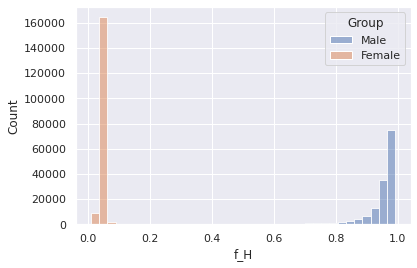

In [35]:
pred_series = pd.Series(predictions, index = cov_train.index, name = 'f_H')
sns.histplot(x ='f_H', hue = 'Group', data = pd.concat([cov_train.Group.replace({0: 'Male', 1: 'Female'}), pred_series], 1))

Unexplained group differences is sign that experts might be biased against one group. Nonetheless, user should take into account domain specific expertise as distribution might differ (e.g. breast cancer might impact male differently and the physician decision might reflect this difference).

/tmp/ipykernel_7621/3579979505.py:3: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  pd.concat([cov_train.Group.replace({0: 'Male', 1: 'Female'}), inf_series], 1).groupby('Group').mean().T.plot.scatter('Female', 'Male')
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


<AxesSubplot:xlabel='Female', ylabel='Male'>

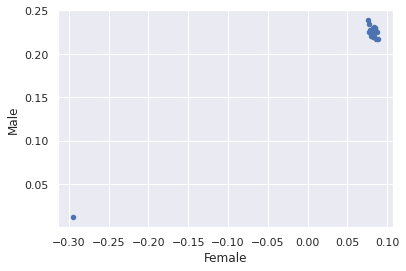

In [51]:
# Mean influence per group
inf_series = pd.DataFrame(influence.T, index = cov_train.index)
pd.concat([cov_train.Group.replace({0: 'Male', 1: 'Female'}), inf_series], 1).groupby('Group').mean().T.plot.scatter('Female', 'Male')

Outliers in this plot represent expert who have a strong impact in a different direction than all other expert. 

In [52]:
# Compute metrics agreeability
center_metric, opposing_metric = compute_agreeability(influence, predictions)

In [53]:
# Analyze confident points
delta = 0.05 # Control which point to consider from a confience point of view

In [57]:
# Select points with high confidence
high_conf = (predictions > (1 - delta)) | (predictions < delta)

In the selected points, one can study the different metrics quantifying the consensus beteween expert obtained for each points.

/tmp/ipykernel_7621/1424857866.py:2: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  sns.histplot(x ='m_1', hue = 'Group', data = pd.concat([cov_train.Group.replace({0: 'Male', 1: 'Female'}), m1_series], 1)[high_conf])


<AxesSubplot:xlabel='m_1', ylabel='Count'>

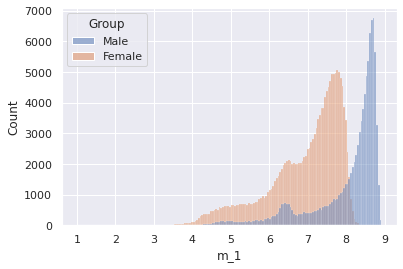

In [63]:
m1_series = pd.Series(center_metric, index = cov_train.index, name = 'm_1')
sns.histplot(x ='m_1', hue = 'Group', data = pd.concat([cov_train.Group.replace({0: 'Male', 1: 'Female'}), m1_series], 1)[high_conf])

This first metric measures the **center of mass**: *higher the value, more experts agrees*. In this scenario, note how the female distribution is shifted due to the bias of one expert. This shift indicates that less experts agree on this group. 

In this context choosing $\gamma_1$ at 6 or 7 allows to capture a large amount of the agreement. 

/tmp/ipykernel_7621/1572707156.py:2: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  sns.histplot(x ='m_2', hue = 'Group', data = pd.concat([cov_train.Group.replace({0: 'Male', 1: 'Female'}), m2_series], 1)[high_conf])


<AxesSubplot:xlabel='m_2', ylabel='Count'>

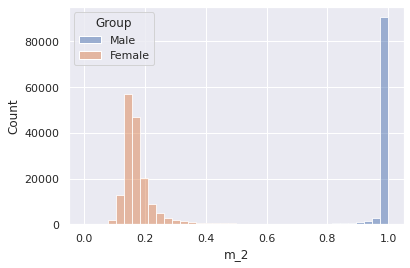

In [65]:
m2_series = pd.Series(opposing_metric, index = cov_train.index, name = 'm_2')
sns.histplot(x ='m_2', hue = 'Group', data = pd.concat([cov_train.Group.replace({0: 'Male', 1: 'Female'}), m2_series], 1)[high_conf])

This second metric measures how **aligned is the influence**: *larger it is, more expert are going in the same direction*.

Here, the shift in the female distribution shows that a small set of expert is driving the decision for this group. To be conservative, one would want to correct for this non consensus, i.e. any threshold $\gamma_2 > 0.4$ would ignore these points.

In [69]:
# Amalgation parameters choice
pi_1 = 6 # Control criterion on centre mass metric
pi_2 = 0.8 # Control criterion on opposing metric
pi_3 = 0.002 # On flatness

Following this choice, one can amalgamte the human decision and the observed outcome.

In [67]:
# Apply criteria on amalgamation
flat_influence = (np.abs(influence) > pi_3).sum(0) == 0
high_agr = (((center_metric > pi_1) & (opposing_metric > pi_2)) | flat_influence) & high_conf
high_agr_correct = ((predictions - tar_train['D']).abs() < delta) & high_agr
print("This choice of parameters leads to an amalgamation of : {:.2f} % of the data".format(100 * np.mean(high_agr_correct)))

This choice of parameters leads to an amalgamation of : 28.88 % of the data


In [68]:
# Create amalgamated labels
tar_train['Ya'] = tar_train['Y1'].astype(int) # Initialize as human decision
tar_train.loc[high_agr_correct, 'Ya'] = tar_train['D'][high_agr_correct] # Change the point to amalgamate

In [ ]:
index_amalg = ((tar_train['D'] == 1) | high_agr_correct) if selective_labels else tar_train['D'].isin([0, 1]) # Retrain the model on the set of observed points
print("Use: {:.2f} % of data".format(100 * index_amalg.mean()))

Use: 100.00 % of data


##### 3. Updated model

In [ ]:
f_A = BinaryMLP(**params)
f_A = f_A.fit(cov_train[index_amalg], tar_train[index_amalg]['Ya'], nur_train[index_amalg])
predictions_amal = f_A.predict(cov_test)
evaluate(predictions_amal)

Loss: 0.307: 100%|██████████| 10/10 [00:16<00:00,  1.69s/it]


ROC Performance
Y1 - 0.638
Y2 - 0.466
YC - 0.604
D - 0.947

Predicted no risk - Group population
Y1 - 0.871
Y2 - 0.871
YC - 0.871
D - 0.871

Real percentage - Group population
Y1 - 0.303
Y2 - 0.502
YC - 0.079
D - 0.954

TNR - Group population
Y1 - 0.320
Y2 - 0.491
YC - 0.082
D - 0.955

FNR - Group population
Y1 - 4.595
Y2 - 3.439
YC - 6.207
D - 0.306


##### 4. Train on observed data

In [ ]:
index_observed = (tar_train['D'] == 1) if selective_labels else tar_train['D'].isin([0, 1])

In [ ]:
f_Y = BinaryMLP(**params)
f_Y = f_Y.fit(cov_train[index_observed], tar_train['Y1'][index_observed], nur_train[index_observed])
predictions = f_Y.predict(cov_test)
evaluate(predictions)

Loss: 0.390: 100%|██████████| 50/50 [01:50<00:00,  2.22s/it]

ROC Performance
Y1 - 0.933
Y2 - 0.261
YC - 0.782
D - 0.299


-----------

##### 5. Hybrid alternative

- Leverage human model in the amalgamation set
- Leverage outcome model on non amalgamation set

Models need to be retrain on their respective subsets and calibrated to ensure to mix

In [ ]:
predictions = predictions_d.copy()

In [ ]:
# Compute which test points are part of A for test set
predictions_test, influence_test = influence_estimate(BinaryMLP, cov_train, tar_train['D'], nur_train, cov_test, params = params, l1_penalties = [0.001, 0.01, 0.1, 1])
center_metric, opposing_metric = compute_agreeability(influence_test)
flat_influence_test = (np.abs(influence_test) > pi_3).sum(0) == 0
high_conf_test = (predictions_test > (1 - delta)) | (predictions_test < delta)
high_agr_test = (((center_metric > pi_1) & (opposing_metric > pi_2)) | flat_influence_test) & high_conf_test
high_agr_correct_test = ((predictions_test - tar_test['D']).abs() < delta) & high_agr_test

Loss: 0.521: 100%|██████████| 50/50 [01:50<00:00,  2.22s/it]


In [ ]:
# Retrain a model on non almagamation only and calibrate: Rely on observed
f_hyb = BinaryMLP(**params)
f_hyb = f_hyb.fit(cov_train[index_observed], tar_train['Y1'][index_observed], nur_train[index_observed], platt_calibration = True)
predictions[~high_agr_correct_test] = f_hyb.predict(cov_test.loc[~high_agr_correct_test])
evaluate(predictions)

Loss: 0.390: 100%|██████████| 50/50 [02:26<00:00,  2.93s/it]


ROC Performance
Y1 - 0.618
Y2 - 0.449
YC - 0.759
D - 0.467
